In [1]:

# Import libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPooling1D, concatenate
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)




In [3]:

# Load and preprocess dataset

train_data = pd.read_csv("train_cleaned.csv")
test_data = pd.read_csv("test_cleaned.csv")

x_train = train_data["review"].astype(str).tolist()
y_train = train_data["label"].values
x_test = test_data["review"].astype(str).tolist()
y_test = test_data["label"].values

# Tokenize
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=max_len, padding='post')
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=max_len, padding='post')

vocab_size = min(max_words, len(tokenizer.word_index) + 1)
print(f"Vocab size: {vocab_size}")


Vocab size: 20000


In [4]:

# Load GloVe embeddings

embedding_dim = 100
embedding_index = {}

# Download GloVe if not exists
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -qo glove.6B.zip

# Load GloVe file
with open("glove.6B.100d.txt", "r", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print("Loaded GloVe vectors:", len(embedding_index))

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


Loaded GloVe vectors: 400000


In [5]:

# Define the CNN model with multiple filters

from tensorflow.keras import regularizers

filter_sizes = [3, 4, 5]
num_filters = 128
dropout_rate = 0.5
l2_reg = 0.01

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)(input_layer)

# Multiple convolution branches
conv_blocks = []
for size in filter_sizes:
    conv = Conv1D(
        filters=num_filters,
        kernel_size=size,
        activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg)
    )(embedding_layer)
    pool = GlobalMaxPooling1D()(conv)
    conv_blocks.append(pool)

concat = concatenate(conv_blocks)
drop = Dropout(dropout_rate)(concat)
output = Dense(1, activation='sigmoid')(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  2,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 128)   │     38,528 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 128)   │     51,328 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 128)   │     64,128 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        385 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,154,369 (8.22 MB)

 Trainable params: 154,369 (603.00 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [6]:

# Train with checkpoint and early stopping

checkpoint_path = "best_multifilter_cnn.keras"

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    x_train_seq,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Save final model
model.save("final_multifilter_cnn.keras")


Epoch 1/10
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6486 - loss: 1.9770
Epoch 1: val_loss improved from inf to 0.57589, saving model to best_multifilter_cnn.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6496 - loss: 1.9656 - val_accuracy: 0.7987 - val_loss: 0.5759
Epoch 2/10
493/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7714 - loss: 0.5961
Epoch 2: val_loss improved from 0.57589 to 0.54545, saving model to best_multifilter_cnn.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7715 - loss: 0.5960 - val_accuracy: 0.8033 - val_loss: 0.5454
Epoch 3/10
490/500 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7763 - loss: 0.5768
Epoch 3: val_loss improved from 0.54545 to 0.53152, saving model to best_multifilter_cnn.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7765 - loss: 0.5766 - val_accuracy: 0.8058 - val_loss: 0.5315
Epoch 4/10
494/500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7840 - loss: 0.5649
Epoch 4: val_loss improv

In [7]:

# Load best model and evaluate

best_model = tf.keras.models.load_model("best_multifilter_cnn.keras")

test_loss, test_acc = best_model.evaluate(x_test_seq, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8252 - loss: 0.4820

✅ Test Accuracy: 0.8243


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.8195    0.8318    0.8256      5000
           1     0.8292    0.8168    0.8230      5000

    accuracy                         0.8243     10000
   macro avg     0.8244    0.8243    0.8243     10000
weighted avg     0.8244    0.8243    0.8243     10000



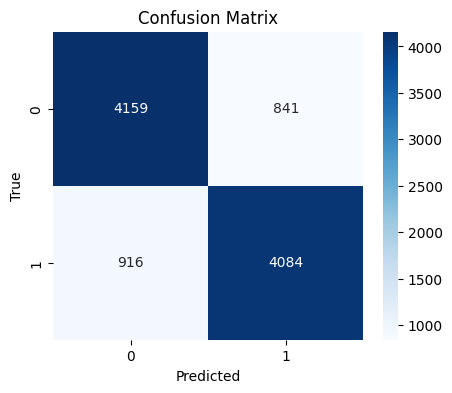

In [8]:

# Classification report and confusion matrix

y_pred_prob = best_model.predict(x_test_seq)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
